In [1]:
import numpy as np
import pickle
from TrainVoxelmorph import VoxelmorphTF
#from trainPytorch import VoxelmorphTorch
from DataHandler import DataHandler
import SimpleITK as sitk
import os
#import tensorflow as tf
#import torch as th
from DataHandler import DataHandler
import pickle
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
mod = 'MR' #MR

In [3]:
def get_moved_points(points: np.array, displacement: sitk.Image) -> np.array:
    displacement_copy = displacement.__copy__()
    displacement_transform = sitk.DisplacementFieldTransform(displacement_copy)
    moved_points = [displacement_transform.TransformPoint(point) for point in points]
    return moved_points

def get_landmarks(fixed_image_path: str, indexing: str = 'zyx', continuous = False, preResample = False):
    model_name = os.path.basename(fixed_image_path).replace('_atn_3.nrrd', '')
    if preResample: 
        loaded_points = pickle.load(open(f'/home/cschellenberger/Documents/vectorPickles/{model_name}_vec_frame1_to_frame2.p', "rb"))
        moving_landmarks = np.array([(float(loaded_points[idx]['1X']), float(loaded_points[idx]['1Y']), float(loaded_points[idx]['1Z']) * 2) for (idx, _) in enumerate(loaded_points)])
        fixed_landmarks = np.array([(float(loaded_points[idx]['2X']), float(loaded_points[idx]['2Y']), float(loaded_points[idx]['2Z']) * 2) for (idx, _) in enumerate(loaded_points)])
    else: 
        #if continuous: loaded_points = pickle.load(open(f'/home/cschellenberger/Documents/vectorPickles/CT_points_t1_t3_withRegion_Continuous/{model_name}_idx.p', "rb"))
        if continuous: loaded_points = pickle.load(open(f'/home/cschellenberger/Documents/vectorPickles/CT_points_t1_t3_withRegion_Spacing1_8/{model_name}_idx.p', "rb"))
        else: loaded_points = pickle.load(open(f'/home/cschellenberger/Documents/vectorPickles/CT_points_t1_t3_withRegion/{model_name}_idx.p', "rb"))
        moving_landmarks = np.array(loaded_points['t1'])
        fixed_landmarks = np.array(loaded_points['t3'])
    regions = np.array(loaded_points['Region'])
    if indexing == 'xzy':
        # swap columns because numpy and vxm use zyx indexing and the data uses xyz indexing
        moving_landmarks[:, [1, 2]] = moving_landmarks[:, [2, 1]]
        fixed_landmarks[:, [1, 2]] = fixed_landmarks[:, [2, 1]]
    elif indexing == 'zyx':
        # swap columns because numpy and vxm use zyx indexing and the data uses xyz indexing
        moving_landmarks[:, [0, 2]] = moving_landmarks[:, [2, 0]]
        fixed_landmarks[:, [0, 2]] = fixed_landmarks[:, [2, 0]]
    elif indexing == 'yxz':
        # swap columns because numpy and vxm use zyx indexing and the data uses xyz indexing
        moving_landmarks[:, [0, 1]] = moving_landmarks[:, [1, 0]]
        fixed_landmarks[:, [0, 1]] = fixed_landmarks[:, [1, 0]]
    else: assert indexing == 'xyz', f'indexing can only be xyz or zyx. Got: {indexing}'
    return moving_landmarks.astype(np.float64), fixed_landmarks.astype(np.float64), regions

In [7]:
if mod == 'CT':
    weights_path = '/home/cschellenberger/Documents/scripts/models/synthetic/lucavxm/weights.h5'
    downsize = 1
    dh = DataHandler(val_images=12)
    dh.get_synthetic_data(
        fixed_path='/home/cschellenberger/datam2olie/synthetic/orig/t3/Synthetic_CT/',
        moving_path='/home/cschellenberger/datam2olie/synthetic/orig/t1/Synthetic_CT/')
elif mod == 'MR':
    #weights_path = '/home/cschellenberger/Documents/scripts/models/synthetic/newT3_best_localmi_reg001_08_1000_st43_lr3e-05_bat1/bestWeights.h5'
    #weights_path = '/home/cschellenberger/Documents/scripts/models/synthetic/localmi_newT3v2_reg001_08_1000_st43_lr1e-05_bat1/bestWeights.h5'
    #weights_path = '/home/cschellenberger/Documents/scripts/models/synthetic/newT3_best_localmi_reg001_08_2nd_1000_st43_lr1e-05_bat1/bestWeights.h5'
    weights_path = '/home/cschellenberger/Documents/scripts/models/synthetic/newT3_best_localmi_reg001_08_2nd_1000_st43_lr3e-05_bat1/bestWeights.h5'
    
    #weights_path = '/home/cschellenberger/Documents/scripts/models/synthetic/l1Reg500_st10_lr0_0005_bat4/bestWeights.h5'
    #weights_path = '/home/cschellenberger/Documents/scripts/models/synthetic/l1l2011000_st24_lr0_001_bat4/bestWeights.h5'
    #weights_path = '/home/cschellenberger/Documents/scripts/models/synthetic/localmi_newT3_reg001_03_1000_st14_lr0_01_bat3/bestWeights.h5'

    downsize = 1
    dh = DataHandler(val_images=12)
    dh.get_synthetic_data(
        fixed_path='/home/cschellenberger/datam2olie/synthetic/orig/t3/Synthetic_CT/',
        moving_path='/home/cschellenberger/datam2olie/synthetic/orig/t1/Synthetic_MR/')
    # dh.get_synthetic_data(
    #     fixed_path='/home/cschellenberger/Documents/newT3Resample1_8',
    #     moving_path='/home/cschellenberger/Documents/T1ResampledSpacing1_8')
i = 0
resErr = 0
dists = {}
moving_image_paths = dh.x_val
fixed_image_paths = dh.y_val
nb_features = [[16, 32, 32, 32], [32, 32, 32, 32, 32, 16, 16]]
#nb_features = [[16, 16, 32, 32], [32, 32, 32, 32, 32, 16, 16]]
#nb_features = [[16, 32, 32, 32], [32, 32, 32, 32, 16, 16]]
#nb_features = [[16, 32, 32, 32], [32, 32, 32, 16, 16]]
#nb_features = [[16, 16, 32, 32], [32, 32, 32, 16, 16]]
device = '/cpu:0'
imgReg = VoxelmorphTF(weights_path, sitk.ReadImage(fixed_image_paths[0]), nb_features, downsize)
for i in range(1):
    fixed_image = sitk.ReadImage(fixed_image_paths[i])
    moving_image = sitk.ReadImage(moving_image_paths[i])
    moving_landmarks, fixed_landmarks, regions = get_landmarks(fixed_image_paths[i], indexing='xyz', continuous=False, preResample=False)
    fixed_landmarks_tmp, moving_landmarks_tmp, regions_tmp = [], [], []
    for j in range(len(fixed_landmarks)):
        if fixed_landmarks[j][2] > 12 and fixed_landmarks[j][2] < 116:
            fixed_landmarks_tmp.append(fixed_landmarks[j])
            moving_landmarks_tmp.append(moving_landmarks[j])
            regions_tmp.append(regions[j])
    fixed_landmarks = np.array(fixed_landmarks_tmp)
    moving_landmarks = np.array(moving_landmarks_tmp)
    regions = regions_tmp
    disp_np = moving_landmarks - fixed_landmarks
    disp_np = np.linalg.norm(disp_np, axis = 1)
    disp_image = sitk.Image(fixed_image.GetSize(), sitk.sitkFloat64)
    disp_image.SetOrigin(fixed_image.GetOrigin())
    disp_image.SetSpacing(fixed_image.GetSpacing())
    for idx, point in enumerate(fixed_landmarks):
        try: disp_image.SetPixel(int(point[0]), int(point[1]), int(point[2]), disp_np[idx])
        except: continue
    moved_img, displacement_np, time = imgReg.register_images(moving_image, fixed_image, device)
    displacement = displacement_np.squeeze()
    displacement[:,:,:,[0,2]] = displacement[:,:,:,[2,0]]
    displacement = sitk.GetImageFromArray(displacement.astype(np.float64), isVector=True)
    displacement.SetSpacing((downsize, downsize, downsize))
    moved_landmarks = get_moved_points(fixed_landmarks, displacement)
    err = moving_landmarks - moved_landmarks
    err = np.linalg.norm(err, axis = 1)
    err_image = sitk.Image(fixed_image.GetSize(), sitk.sitkFloat64)
    err_image.SetSpacing(fixed_image.GetSpacing())
    err_image.SetOrigin(fixed_image.GetOrigin())
    for idx, point in enumerate(fixed_landmarks):
        try: err_image.SetPixel(int(point[0]), int(point[1]), int(point[2]), err[idx])
        except: continue
    dists[f'dist{i}'] = err.mean()

In [19]:
print(np.array(list(dists.values())).mean() / 1.8)

9.975942749544165


In [9]:
dh = DataHandler(val_images=12)
dh.get_synthetic_data(
    fixed_path='/home/cschellenberger/datam2olie/synthetic/native/t3/Synthetic_CT/',
    moving_path='/home/cschellenberger/datam2olie/synthetic/native/t1/Synthetic_MR/')
moving_image_paths = dh.x_val
fixed_image_paths = dh.y_val
fixed_image = sitk.ReadImage(fixed_image_paths[1])
moving_image = sitk.ReadImage(moving_image_paths[1])

In [269]:
from matplotlib.pyplot import imsave
import matplotlib.cm as cm
moved_img_x = sitk.GetArrayFromImage(moved_img)[64, :, :]
moved_img_y = sitk.GetArrayFromImage(moved_img)[:, 128, :]
moved_img_z = sitk.GetArrayFromImage(moved_img)[:, :, 128]
fixed_image_save_x = sitk.GetArrayFromImage(fixed_image)[64, :, :]
fixed_image_save_y = sitk.GetArrayFromImage(fixed_image)[:, 128, :]
fixed_image_save_z = sitk.GetArrayFromImage(fixed_image)[:, :, 128]
cFilter.SetCheckerPattern(10)
checkerboardx = sitk.GetArrayFromImage(cFilter.Execute(sitk.GetImageFromArray(moved_img_x), sitk.GetImageFromArray(fixed_image_save_x)))
checkerboardy = sitk.GetArrayFromImage(cFilter.Execute(sitk.GetImageFromArray(moved_img_y), sitk.GetImageFromArray(fixed_image_save_y)))
checkerboardz = sitk.GetArrayFromImage(cFilter.Execute(sitk.GetImageFromArray(moved_img_z), sitk.GetImageFromArray(fixed_image_save_z)))
imsave(f'../displacementVis/moved_img_lr_checker_x.jpg', np.flip(checkerboardx, 0), cmap=cm.gray)
imsave(f'../displacementVis/moved_img_lr_checke_y.jpg', np.flip(checkerboardy, 0), cmap=cm.gray)
imsave(f'../displacementVis/moved_img_lr_checke_z.jpg', np.flip(checkerboardz, 0), cmap=cm.gray)

In [ ]:
pickle.dump(dists, open("./CTCTResults.p", "wb"))

In [9]:
print(np.array(list(dists.values())).mean() * 1.8)

3.7326975389906996


In [6]:
voxelmorphNewT3 = pickle.load(open("./voxelmorphNewT3.p", "rb"))
print(voxelmorphNewT3)

{'dist0': 2.4072285578017207, 'dist1': 2.4706910163210742, 'dist2': 2.9619385814489396, 'dist3': 3.3946235629806782, 'dist4': 3.208577058299575, 'dist5': 3.1346790515009144, 'dist6': 3.005366124285686, 'dist7': 2.6754960599367754, 'dist8': 2.9929210570648026, 'dist9': 3.33729451035277, 'dist10': 3.0376141518436017, 'dist11': 2.897760174122357}


In [3]:
#pickle.dump(dists, open("./1_8SpaingResults.p", "wb"))
dists = pickle.load(open("./1_8SpaingResults.p", "rb"))
print(dists)
print(np.array(list(dists.values())).mean() * 1.8)

{'dist0': 2.4072285578017207, 'dist1': 2.4706910163210742, 'dist2': 2.9619385814489396, 'dist3': 3.3946235629806782, 'dist4': 3.208577058299575, 'dist5': 3.1346790515009144, 'dist6': 3.005366124285686, 'dist7': 2.6754960599367754, 'dist8': 2.9929210570648026, 'dist9': 3.33729451035277, 'dist10': 3.0376141518436017, 'dist11': 2.897760174122357}
5.328628485893834


In [6]:
#pickle.dump(dists, open("./MRCTnnResults.p", "wb"))
dists = pickle.load(open("./MRCTnnResults.p", "rb"))
print(dists)
print(np.array(list(dists.values())).mean())

{'dist6007156': 4.015159793232525, 'dist10994585': 5.409153880639185, 'dist5852050': 4.613737939798679, 'dist8400958': 5.438661829317504, 'dist6993174': 4.969457958616317, 'dist6972245': 6.211196812193097, 'dist6594237': 4.53861823535224, 'dist4789637': 4.236072352119008, 'dist4943592': 5.061486676222035, 'dist9943649': 5.761462950724967, 'dist5852716': 4.17665249431583, 'dist3946277': 3.923931267849588}
4.862966015865081


In [4]:
#pickle.dump(dists, open("./MRResults.p", "wb"))
dists = pickle.load(open("./MRResults.p", "rb"))
print(dists)
print(np.array(list(dists.values())).mean() * 2)

{'dist6007156': 2.249243396404429, 'dist10994585': 2.379843674908939, 'dist5852050': 3.0623163349607765, 'dist8400958': 3.418824875404383, 'dist6993174': 2.915874846497241, 'dist6972245': 3.058388413863964, 'dist6594237': 3.1440480984710124, 'dist4789637': 2.686767851013032, 'dist4943592': 3.027216062358819, 'dist9943649': 3.078268711083635, 'dist5852716': 2.796352679604165, 'dist3946277': 2.8820865709196792}
5.78320525258168


In [28]:
#pickle.dump(dists, open("./MRResults.p", "wb"))
dists = pickle.load(open("./CTResults.p", "rb"))
print(dists)
print(np.array(list(dists.values())).mean())

{'dist6007156': 3.0932637711261513, 'dist10994585': 2.9399554861943864, 'dist5852050': 4.033361024840726, 'dist8400958': 3.8760748710127677, 'dist6993174': 4.1376912172616915, 'dist6972245': 4.06611007641365, 'dist6594237': 3.820950656118513, 'dist4789637': 3.1978828805178012, 'dist4943592': 4.140941087510519, 'dist9943649': 4.007488922954617, 'dist5852716': 3.509550274204018, 'dist3946277': 3.9691001997335613}
3.7326975389906996


In [5]:
err.mean()

2.474180968457445

In [8]:
from pyM2aia import M2aiaOnlineHelper
M2aiaHelper = M2aiaOnlineHelper("ipynbViewer", "jtfc.de:5050/m2aia/m2aia-no-vnc:with_exit", "8898")
#trueMoving = sitk.ReadImage(moving_image_paths[0].replace('t1', 't3').replace('act_1', 'act_3'))
with M2aiaHelper as helper:
    helper.show({"True Error": disp_image, "Moving": moving_image, "Fixed": fixed_image, "Error": err_image, "Moved": moved_img, "Displacement field": displacement})

You can find your images @  http://141.19.142.80:8898



In [76]:
from matplotlib.pyplot import imsave
import matplotlib.cm as cm
moving_image_save = sitk.GetArrayFromImage(moving_image)[64, :, :]
fixed_image_save = sitk.GetArrayFromImage(fixed_image)[64, :, :]
err_image_save = sitk.GetArrayFromImage(err_image)[64, :, :]
errPre_image_save = sitk.GetArrayFromImage(disp_image)[64, :, :]
moved_img_save = sitk.GetArrayFromImage(moved_img)[64, :, :]
displacement_save = sitk.GetArrayFromImage(displacement)
displacement_save = np.linalg.norm(displacement_save, axis = 3)[64, :, :]
cFilter = sitk.CheckerBoardImageFilter()
cFilter.SetCheckerPattern(10)
checkerboard = sitk.GetArrayFromImage(cFilter.Execute(sitk.GetImageFromArray(moved_img_save), sitk.GetImageFromArray(fixed_image_save)))
imsave(f'../displacementVis/moving_image_y.jpg', np.flip(moving_image_save, 0), cmap=cm.gray)
imsave(f'../displacementVis/fixed_image_y.jpg', np.flip(fixed_image_save, 0), cmap=cm.gray)
imsave(f'../displacementVis/errPre_image_y.jpg', np.flip(errPre_image_save, 0), cmap=cm.gray)
imsave(f'../displacementVis/err_image_y.jpg', np.flip(err_image_save, 0), cmap=cm.gray)
imsave(f'../displacementVis/moved_img_y.jpg', np.flip(moved_img_save, 0), cmap=cm.gray)
imsave(f'../displacementVis/displacement_y.jpg', np.flip(displacement_save, 0), cmap=cm.gray)
imsave(f'../displacementVis/checkerboard_y.jpg', np.flip(checkerboard, 0), cmap=cm.gray)


In [84]:
sitk.GetArrayFromImage(displacement).shape

(128, 256, 256, 3)

In [93]:
sitk.GetArrayFromImage(displacement)[64, 128, :, 1].shape

(256,)

In [100]:
sitk.GetArrayFromImage(displacement)[64, :, :, 1].shape

(256, 256)

In [117]:
xd = [[xd[i, j] for i in range(0, 256, 8)] for j in range(0, 256, 8)]

In [144]:
sitk.GetArrayFromImage(displacement)[:, 128, :, 2].shape

(128, 256)

In [45]:
import matplotlib.colors as colors

In [75]:
map(norm(color_array.tolist())).tolist()

array([[1.46200e-03, 4.66000e-04, 1.38660e-02, 1.00000e+00],
       [2.94320e-02, 2.15030e-02, 1.14621e-01, 1.00000e+00]])

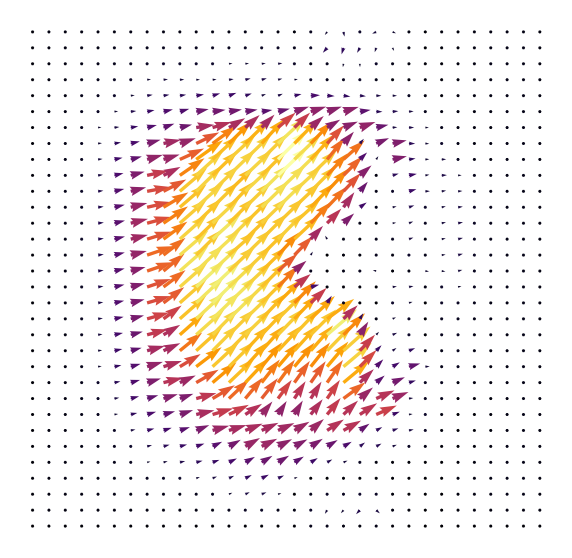

In [145]:
fig, ax = plt.subplots()
fig.set_size_inches(10, 10)
disnp = sitk.GetArrayFromImage(displacement)  
xd = disnp[64, :, :, 1]
yd = disnp[64, :, :, 2]
xd = [[xd[i, j] for i in range(0, 256, 8)] for j in range(0, 256, 8)]
yd = [[yd[i, j] for i in range(0, 256, 8)] for j in range(0, 256, 8)]
color_array = np.sqrt(np.square(xd) + np.square(yd))
ax.axis('off')
plt.rcParams['image.cmap'] = 'inferno'
ax.quiver(xd, yd, color_array, angles = 'xy', width = 0.006)
plt.savefig('../displacementVis/quivery.jpg')

In [4]:
def getPoint(point):
    return fixed_image.TransformPhysicalPointToIndex(fixed_image.TransformContinuousIndexToPhysicalPoint(point))

In [13]:
def get_moved_points(points: np.array, displacement: sitk.Image) -> np.array:
    displacement_copy = displacement.__copy__()
    displacement_transform = sitk.DisplacementFieldTransform(displacement_copy)
    moved_points = [displacement_transform.TransformPoint(point) for point in points]
    return moved_points

In [ ]:
from pyM2aia import M2aiaOnlineHelper
M2aiaHelper = M2aiaOnlineHelper("ipynbViewer", "jtfc.de:5050/m2aia/m2aia-no-vnc:with_exit", "8899")
#trueMoving = sitk.ReadImage(moving_image_paths[0].replace('t1', 't3').replace('act_1', 'act_3'))
with M2aiaHelper as helper:
    helper.show({"Moving": moving_image, "Fixed": fixed_image, "newT3": newT3})

In [15]:
def findPixel(i, j, k):
    if k > 0 and displacement.GetPixel(i, j, k - 1) != (0, 0, 0): return displacement.GetPixel(i, j, k - 1)
    if k < 127 and displacement.GetPixel(i, j, k + 1) != (0, 0, 0): return displacement.GetPixel(i, j, k + 1)
    return (0, 0, 0)

In [220]:
def getLandmarksInImage(fLandmarks, mLandmarks):
    fixed_landmarks_temp = []
    moving_landmarks_temp = []
    for i in range(len(fLandmarks)):
        if all([x > 0 for x in fLandmarks[i]]) and fLandmarks[i][2] < moving_image.GetSize()[2] and fLandmarks[i][0] < moving_image.GetSize()[0] and fLandmarks[i][1] < moving_image.GetSize()[1]:
            fixed_landmarks_temp.append(fLandmarks[i])
            moving_landmarks_temp.append(mLandmarks[i])
    return np.array(fixed_landmarks_temp), np.array(moving_landmarks_temp)

In [15]:
moving_image.GetSize()

(450, 330, 70)

In [34]:
moving_landmarks, fixed_landmarks, regions = get_landmarks(fixed_image_paths[idx], indexing='xyz', continuous = True, preResample= True)

In [239]:
dh = DataHandler(val_images=12)
dh.get_synthetic_data(
    fixed_path='/home/cschellenberger/datam2olie/synthetic/orig/t3/Synthetic_CT/',
    moving_path='/home/cschellenberger/datam2olie/synthetic/orig/t1/Synthetic_MR/')
moving_image_paths = dh.x_val
fixed_image_paths = dh.y_val
for idx in range(1):
    moving_image = sitk.ReadImage(moving_image_paths[0])
    fixed_image = sitk.ReadImage(fixed_image_paths[0])
    fixed_landmarks, moving_landmarks, regions = get_landmarks(fixed_image_paths[idx], indexing='xyz', continuous = True, preResample=True)
    fixed_landmarks, moving_landmarks = getLandmarksInImage(fixed_landmarks, moving_landmarks)
    disp_np = moving_landmarks - fixed_landmarks
    #moving_landmarks, fixed_landmarks, regions = get_landmarks(fixed_image_paths[idx], indexing='xyz')
    #fixed_landmarks, moving_landmarks = getLandmarksInImage(fixed_landmarks, moving_landmarks)
    displacement = sitk.Image(moving_image.GetSize(), sitk.sitkVectorFloat64)
    for value, point in zip(disp_np, fixed_landmarks):
        point = fixed_image.TransformPhysicalPointToIndex(fixed_image.TransformContinuousIndexToPhysicalPoint(point))
        try: displacement.SetPixel(point[0], point[1], point[2], value)
        except: continue
    #displacement = resample_image_0_0_0_centered(displacement, np.array([256, 256, 128]), np.array([1, 1, 1]))
    #displacement.SetOrigin((0, 0, 0))
    moved_landmarks = get_moved_points(fixed_landmarks, displacement)
    #moving_landmarks = np.array([[int(e[0]), int(e[1]), int(e[2])] for e in moving_landmarks])
    #moved_landmarks = np.array([[int(e[0]), int(e[1]), int(e[2])] for e in moved_landmarks])
    err = moving_landmarks - moved_landmarks
    err = np.linalg.norm(err, axis = 1)
    print(err.mean())

1.6057833607346345e-17


In [240]:
displacement.SetSpacing(fixed_image.GetSpacing())
displacement.SetOrigin(fixed_image.GetOrigin())
def get_moved_image(image: sitk.Image, displacement: sitk.Image) -> np.array:
    resampler = sitk.ResampleImageFilter()
    displacement_copy = displacement.__copy__()
    displacement_transform = sitk.DisplacementFieldTransform(sitk.Cast(displacement_copy, sitk.sitkVectorFloat64))
    ##ref übergeben
    resampler.SetReferenceImage(image)
    resampler.SetTransform(displacement_transform)
    return resampler.Execute(image)

In [242]:
movedTRE = get_moved_image(fixed_image, displacement)

In [241]:
err_image = sitk.Image(fixed_image.GetSize(), sitk.sitkFloat64)
err_image.SetSpacing(fixed_image.GetSpacing())
err_image.SetOrigin(fixed_image.GetOrigin())
for idx, point in enumerate(fixed_landmarks):
    try: err_image.SetPixel(int(point[0]), int(point[1]), int(point[2]), err[idx])
    except: continue

In [80]:
def resample_image(image, size, spacing, origin) -> sitk.Image:
    resampler = sitk.ResampleImageFilter()
    resampler.SetSize(size.tolist())
    #resampler.SetOutputSpacing(spacing.tolist())
    #resampler.SetOutputOrigin(origin.tolist())
    image_resampled = resampler.Execute(image)
    return image_resampled

def resample_image_0_0_0_centered(image, size: np.array,
                                  spacing: np.array) -> sitk.Image:
    new_origin = calculate_origin(image)
    image.SetOrigin(new_origin.tolist())
    new_origin = calculate_origin(image, size, spacing)
    image_resampled = resample_image(image, size, spacing, new_origin)
    return image_resampled

def calculate_origin(image: sitk.Image, size=None, spacing=None) -> np.array:
    if size is None or spacing is None:
        size = np.array(image.GetSize())
        spacing = np.array(image.GetSpacing())
        direction = np.array(image.GetDirection()).reshape((3, 3))
        return -size * (direction @ spacing) / 2.0
    else:
        return -size * spacing / 2.0

In [34]:
err = fixed_landmarks - moved_landmarks
err = np.linalg.norm(err, axis = 1)
print(err.mean())

1.0357928891011452


In [43]:
[x for x in reg if "lung" in x]

['known_vector_llung', 'known_vector_rlung', 'known_vector_veins_lung']

In [42]:
df = pd.DataFrame()
df['Region'] = regions
reg = df.groupby(df['Region']).value_counts().index

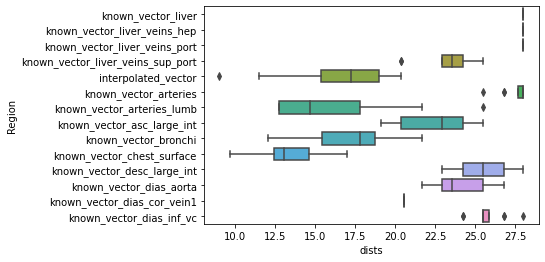

In [17]:
res = pd.DataFrame()
regs = pd.DataFrame()
for i in range(len(dh.x_val)):
    fixed_image = sitk.ReadImage(fixed_image_paths[i])
    moving_landmarks, fixed_landmarks, regions = get_landmarks(fixed_image_paths[i], indexing='xyz', preResample = False)
    df = pd.DataFrame()
    df['Region'] = regions
    if i == 0:
        order = df.groupby(df['Region']).value_counts().index
        regs['Region'] = order[order.str.contains('liver')].tolist() + order[0:10].tolist()
    df['dists'] = np.linalg.norm(moving_landmarks * 1.8 - fixed_landmarks * 1.8, axis = 1)
    median = df.groupby('Region').median().reset_index()
    median = median.set_index('Region').loc[regs['Region']].reset_index()
    res = pd.concat([res, median])
ax = sns.boxplot(y = res['Region'], x = res['dists'], orient='h')

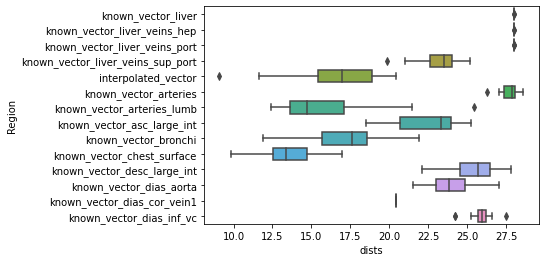

In [16]:
res = pd.DataFrame()
regs = pd.DataFrame()
for i in range(len(dh.x_val)):
    fixed_image = sitk.ReadImage(fixed_image_paths[i])
    moving_landmarks, fixed_landmarks, regions = get_landmarks(fixed_image_paths[i], indexing='xyz', preResample = True)
    df = pd.DataFrame()
    df['Region'] = regions
    if i == 0:
        order = df.groupby(df['Region']).value_counts().index
        regs['Region'] = order[order.str.contains('liver')].tolist() + order[0:10].tolist()
    df['dists'] = np.linalg.norm(moving_landmarks - fixed_landmarks, axis = 1)
    median = df.groupby('Region').median().reset_index()
    median = median.set_index('Region').loc[regs['Region']].reset_index()
    res = pd.concat([res, median])
ax = sns.boxplot(y = res['Region'], x = res['dists'], orient='h')

In [15]:
res = pd.DataFrame()
for i in range(len(dh.x_val)):
    fixed_image = sitk.ReadImage(fixed_image_paths[i])
    moving_landmarks, fixed_landmarks, regions = get_landmarks(fixed_image_paths[i], indexing='xyz', preResample = True)
    df = pd.DataFrame()
    df['Region'] = regions
    if i == 0:
        order = df.groupby(df['Region']).value_counts().index
        res['Region'] = order[order.str.contains('liver')].tolist() + order[0:10].tolist()
    df['dists'] = np.linalg.norm(moving_landmarks - fixed_landmarks, axis = 1)
    quantiles = df.groupby('Region').quantile([0.25, 0.5, 0.75]).reset_index()
    quantiles = quantiles.pivot(index='Region', columns='level_1', values='dists').reset_index().set_index('Region').reset_index()
    low = df.groupby('Region').min().reset_index()
    hi = df.groupby('Region').max().reset_index()
    whislo = quantiles[0.25] - (quantiles[0.75] - quantiles[0.25]) * 1.5
    whishi = quantiles[0.75] + (quantiles[0.75] - quantiles[0.25]) * 1.5
    quantiles['whislo'] = [low.iloc[j]['dists'] if low.iloc[j]['dists'] > whislo.iloc[j] else whislo.iloc[j] for j in range(len(low))]
    quantiles['whishi'] = [hi.iloc[j]['dists'] if hi.iloc[j]['dists'] < whishi.iloc[j] else whishi.iloc[j] for j in range(len(hi))]
    quantiles['bxp_data'] = quantiles[['whislo', 0.25, 0.5, 0.75, 'whishi']].values.tolist()
    quantiles = quantiles.set_index('Region').loc[res['Region']].reset_index()
    if i == 0: res['bxp_data'] = quantiles['bxp_data']
    else: res['bxp_data'] = [np.add(x, y) for x, y in zip(res['bxp_data'], quantiles['bxp_data'])]
res['bxp_data'] = [np.divide(bxp_data, len(dh.x_val)) for bxp_data in res['bxp_data']]

[Text(0, 0, 'known_vector_liver'),
 Text(0, 1, 'known_vector_liver_veins_hep'),
 Text(0, 2, 'known_vector_liver_veins_port'),
 Text(0, 3, 'known_vector_liver_veins_sup_port'),
 Text(0, 4, 'interpolated_vector'),
 Text(0, 5, 'known_vector_arteries'),
 Text(0, 6, 'known_vector_arteries_lumb'),
 Text(0, 7, 'known_vector_asc_large_int'),
 Text(0, 8, 'known_vector_bronchi'),
 Text(0, 9, 'known_vector_chest_surface'),
 Text(0, 10, 'known_vector_desc_large_int'),
 Text(0, 11, 'known_vector_dias_aorta'),
 Text(0, 12, 'known_vector_dias_cor_vein1'),
 Text(0, 13, 'known_vector_dias_inf_vc')]

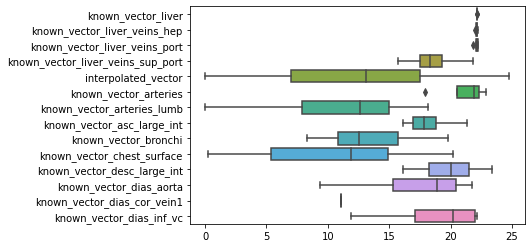

In [16]:
ax = sns.boxplot(data = res['bxp_data'], orient='h')
ax.set_yticklabels(res['Region'])

In [41]:
res = pd.DataFrame()
for i in range(len(dh.x_val)):
    fixed_image = sitk.ReadImage(fixed_image_paths[i])
    moving_landmarks, fixed_landmarks, regions = get_landmarks(fixed_image_paths[i], indexing='xyz', preResample = True)
    df = pd.DataFrame()
    df['Region'] = regions
    df = df.groupby('Region').value_counts().reset_index()
    df.columns = ['Region', 'counts']
    if i == 0: res = df
    else: 
        res = pd.merge(res, df, on = 'Region')
        res['counts'] = res['counts_x'] + res['counts_y']
        res = res.drop(['counts_x', 'counts_y'], axis = 1)
print(res[res['Region'].str.contains('liver')])

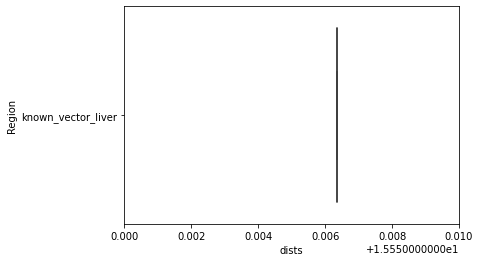

In [15]:
res = pd.DataFrame()
bxpDict = {}
for i in range(1):
    fig = plt.plot()
    fixed_image = sitk.ReadImage(fixed_image_paths[i])
    moving_landmarks, fixed_landmarks, regions = get_landmarks(fixed_image_paths[i], indexing='xyz', preResample = False)
    df = pd.DataFrame()
    df['dists'] = np.linalg.norm(moving_landmarks - fixed_landmarks, axis = 1)
    df['Region'] = regions
    df = df[df['Region'] == 'known_vector_liver']
    ax = sns.boxplot(data = df, x = 'dists', y = 'Region')
    ax.set_xlim(15.55, 15.56)
    plt.show()

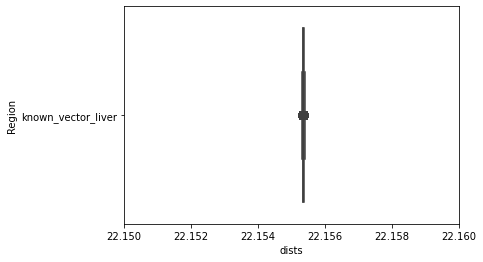

In [16]:
res = pd.DataFrame()
bxpDict = {}
for i in range(1):
    fig = plt.plot()
    fixed_image = sitk.ReadImage(fixed_image_paths[i])
    moving_landmarks, fixed_landmarks, regions = get_landmarks(fixed_image_paths[i], indexing='xyz', preResample = True)
    df = pd.DataFrame()
    df['dists'] = np.linalg.norm(moving_landmarks - fixed_landmarks, axis = 1)
    df['Region'] = regions
    df = df[df['Region'] == 'known_vector_liver']
    ax = sns.boxplot(data = df, x = 'dists', y = 'Region')
    ax.set_xlim(22.15, 22.16)
    plt.show()

In [29]:
res = pd.DataFrame()
fixed_image = sitk.ReadImage(fixed_image_paths[0])
moving_landmarks, fixed_landmarks, regions = get_landmarks(fixed_image_paths[0], indexing='xyz', preResample = True)
df = pd.DataFrame()
df['Region'] = regions
df = df.groupby('Region').value_counts().reset_index()

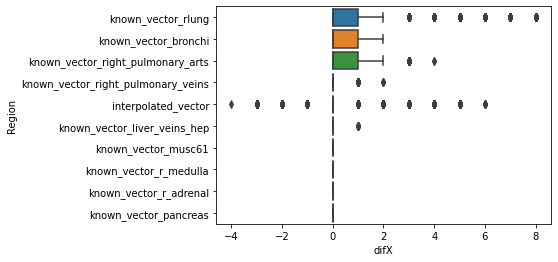

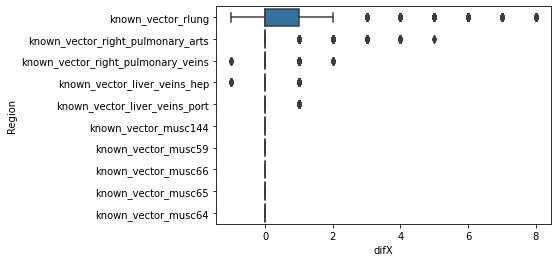

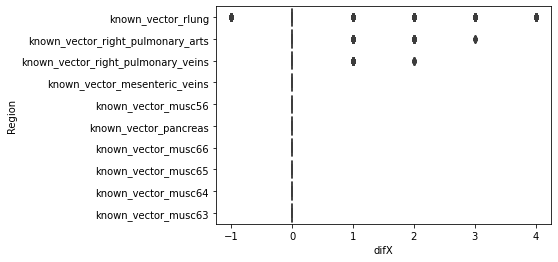

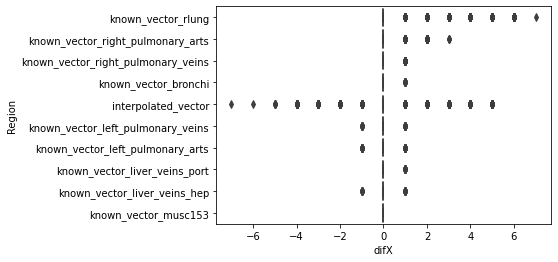

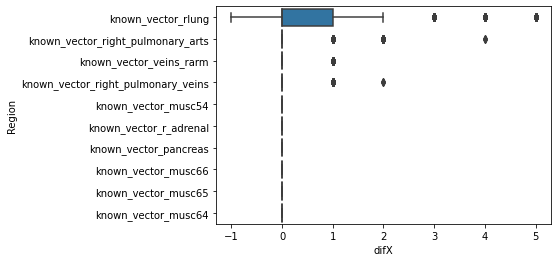

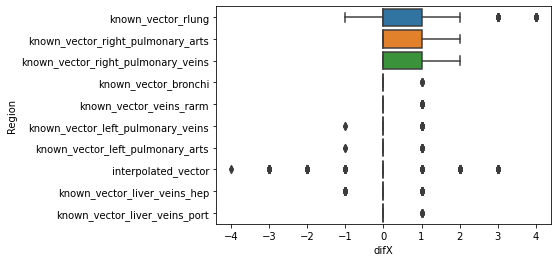

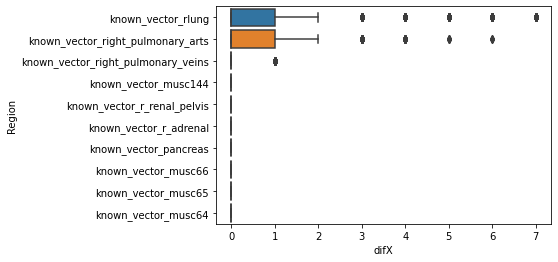

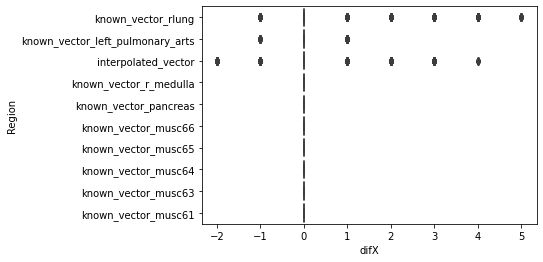

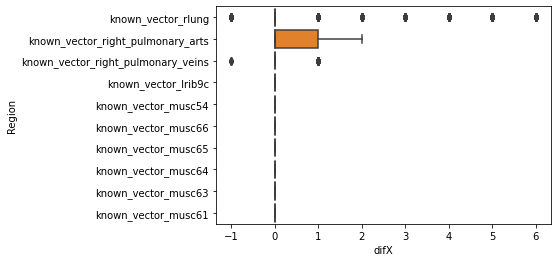

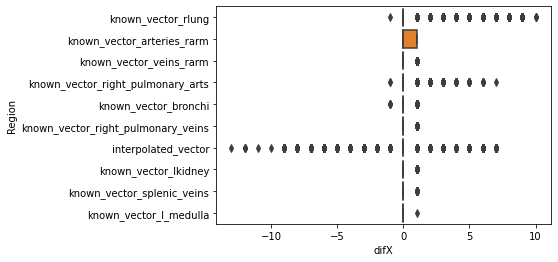

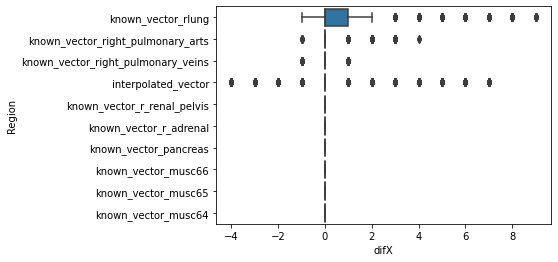

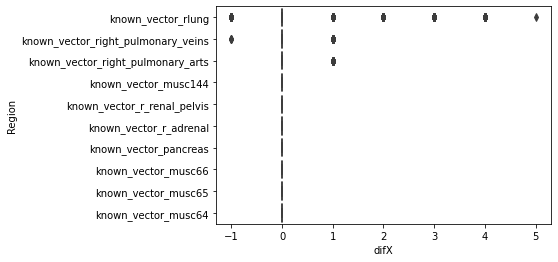

In [26]:
res = pd.DataFrame()
bxpDict = {}
for i in range(len(dh.x_val)):
    fig = plt.plot()
    fixed_image = sitk.ReadImage(fixed_image_paths[i])
    moving_landmarks, fixed_landmarks, regions = get_landmarks(fixed_image_paths[i], indexing='xyz')
    fixed_landmarks = np.transpose(fixed_landmarks)
    moving_landmarks = np.transpose(moving_landmarks)
    df = pd.DataFrame()
    for idx, p in enumerate(['X', 'Y', 'Z']):
        df[f't1{p}'] = moving_landmarks[idx]
        df[f't3{p}'] = fixed_landmarks[idx]
        df[f'dif{p}'] = df[f't1{p}'] - df[f't3{p}']
    df['Region'] = regions
    dist = df.groupby(df['Region']).mean().sort_values('difX', ascending = False).index[:10]
    bxpDict[f'bxp{i}'] = sns.boxplot(data = df, x = 'difX', y = 'Region', order = dist)
    plt.show()


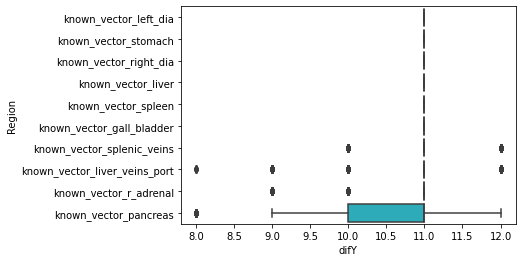

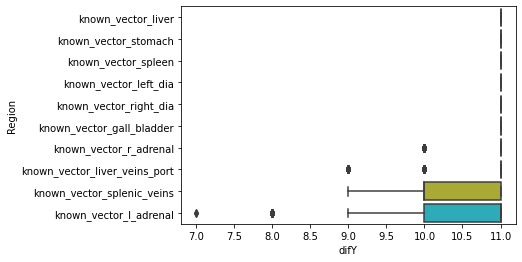

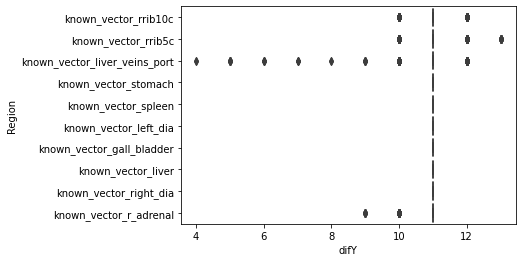

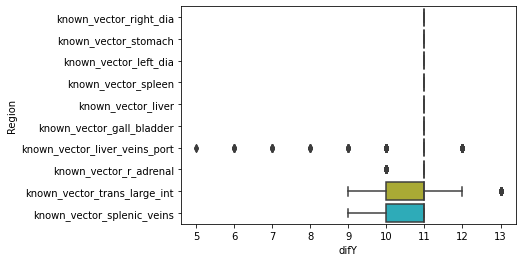

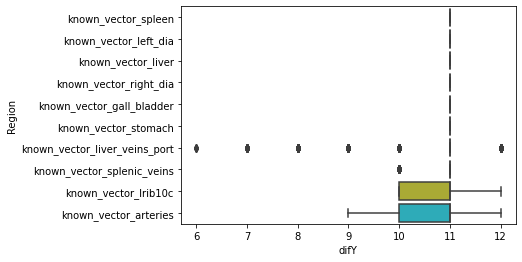

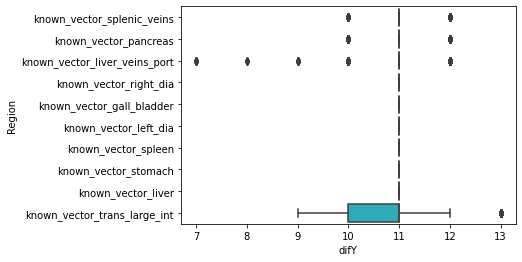

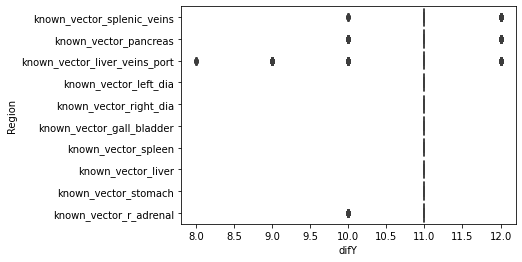

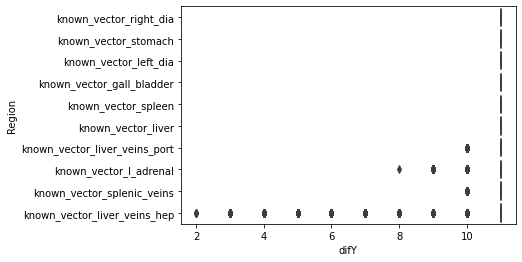

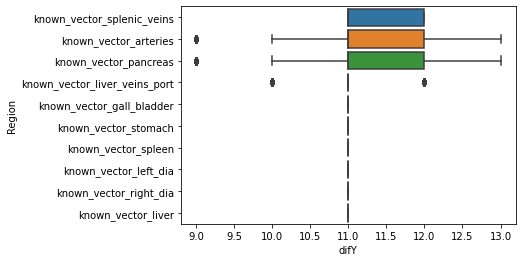

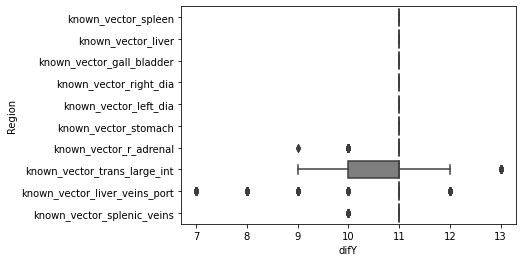

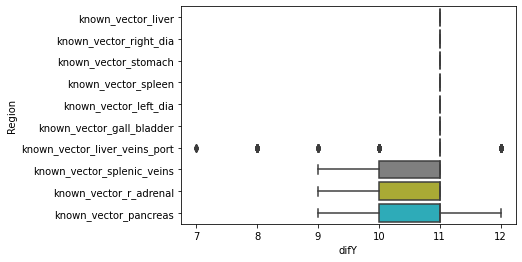

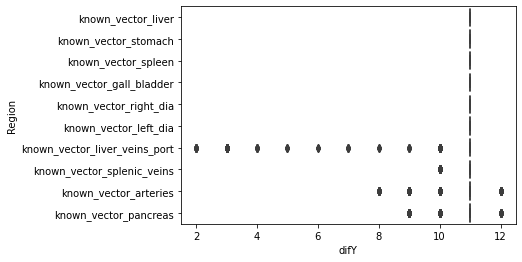

In [27]:
res = pd.DataFrame()
bxpDict = {}
for i in range(len(dh.x_val)):
    fig = plt.plot()
    fixed_image = sitk.ReadImage(fixed_image_paths[i])
    moving_landmarks, fixed_landmarks, regions = get_landmarks(fixed_image_paths[i], indexing='xyz')
    fixed_landmarks = np.transpose(fixed_landmarks)
    moving_landmarks = np.transpose(moving_landmarks)
    df = pd.DataFrame()
    for idx, p in enumerate(['X', 'Y', 'Z']):
        df[f't1{p}'] = moving_landmarks[idx]
        df[f't3{p}'] = fixed_landmarks[idx]
        df[f'dif{p}'] = df[f't1{p}'] - df[f't3{p}']
    df['Region'] = regions
    dist = df.groupby(df['Region']).mean().sort_values('difY', ascending = False).index[:10]
    bxpDict[f'bxp{i}'] = sns.boxplot(data = df, x = 'difY', y = 'Region', order = dist)
    plt.show()

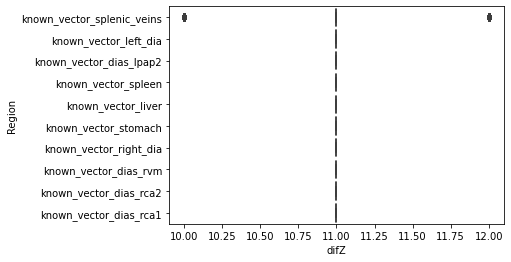

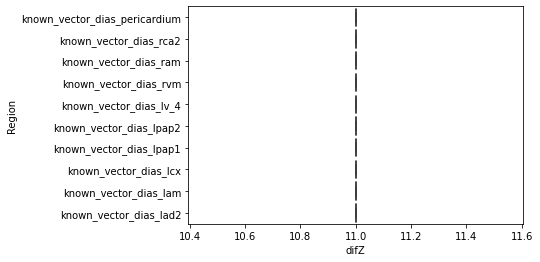

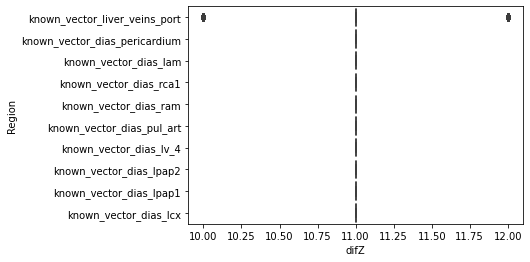

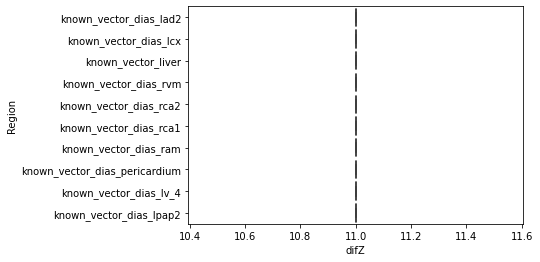

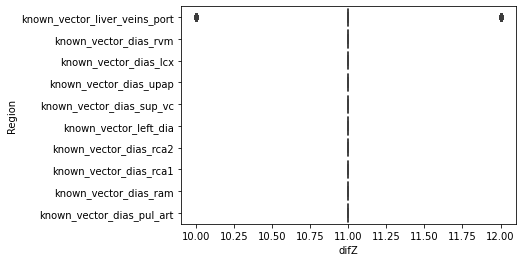

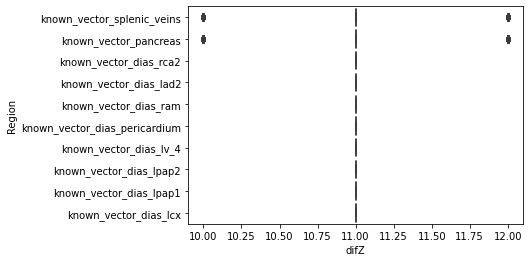

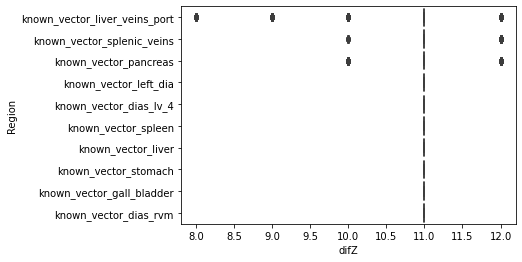

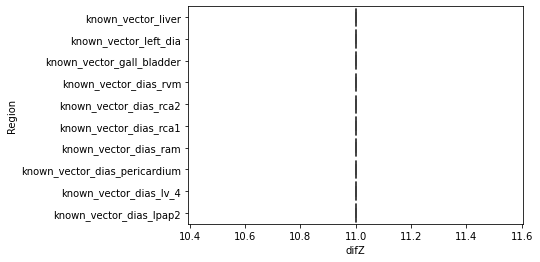

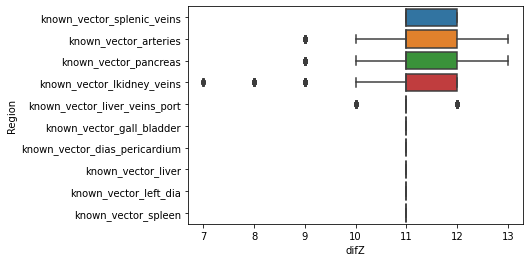

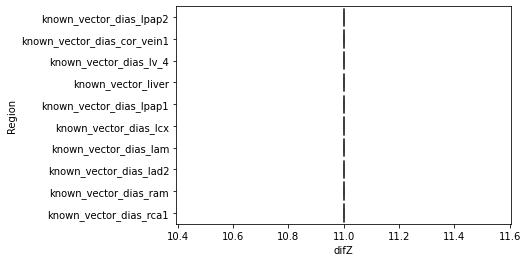

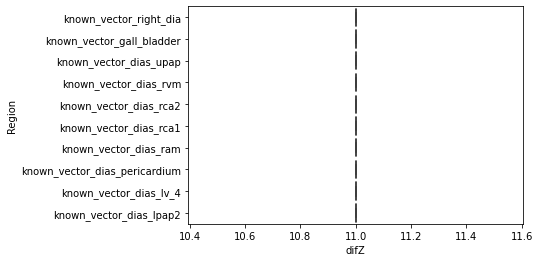

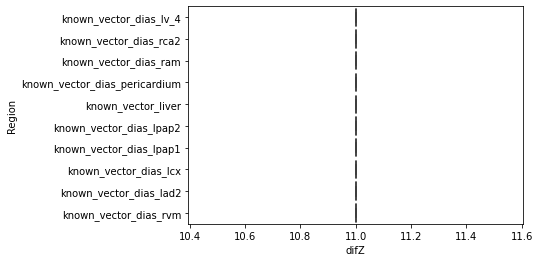

In [28]:
res = pd.DataFrame()
bxpDict = {}
for i in range(len(dh.x_val)):
    fig = plt.plot()
    fixed_image = sitk.ReadImage(fixed_image_paths[i])
    moving_landmarks, fixed_landmarks, regions = get_landmarks(fixed_image_paths[i], indexing='xyz')
    fixed_landmarks = np.transpose(fixed_landmarks)
    moving_landmarks = np.transpose(moving_landmarks)
    df = pd.DataFrame()
    for idx, p in enumerate(['X', 'Y', 'Z']):
        df[f't1{p}'] = moving_landmarks[idx]
        df[f't3{p}'] = fixed_landmarks[idx]
        df[f'dif{p}'] = df[f't1{p}'] - df[f't3{p}']
    df['Region'] = regions
    dist = df.groupby(df['Region']).mean().sort_values('difZ', ascending = False).index[:10]
    bxpDict[f'bxp{i}'] = sns.boxplot(data = df, x = 'difZ', y = 'Region', order = dist)
    plt.show()

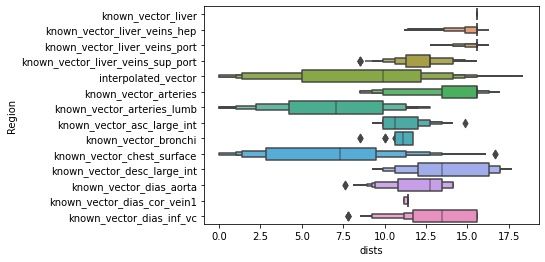

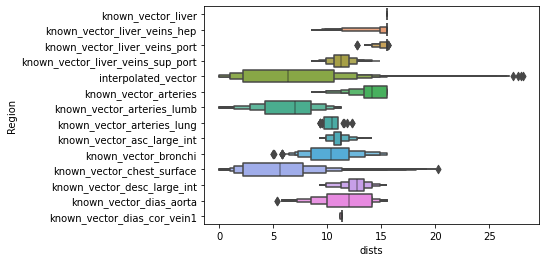

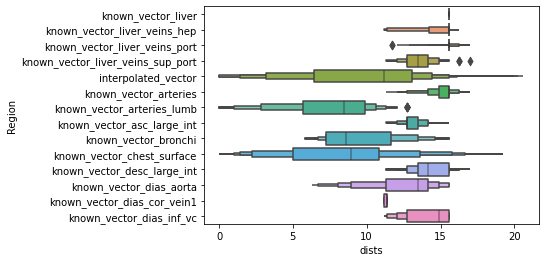

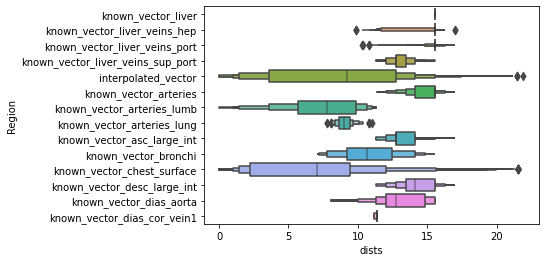

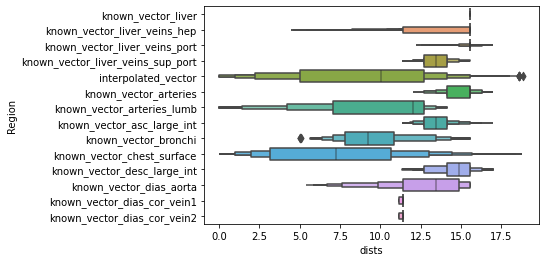

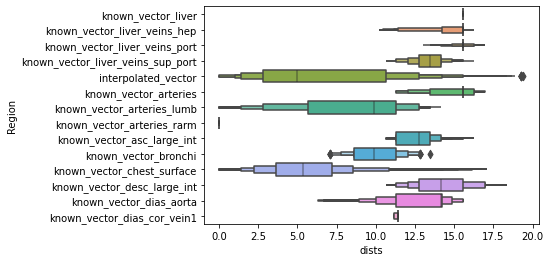

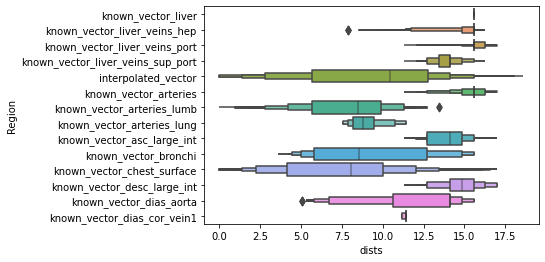

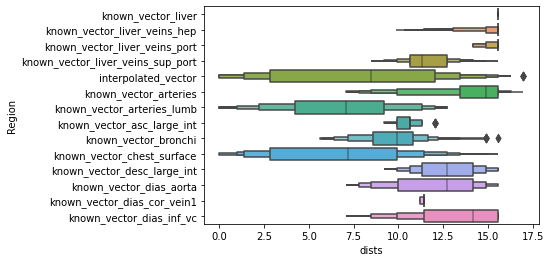

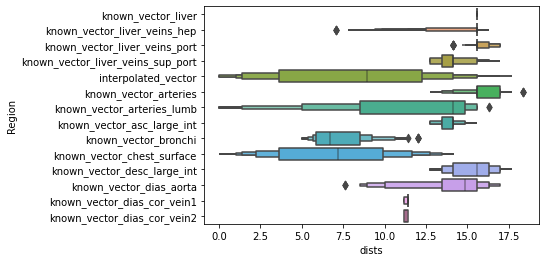

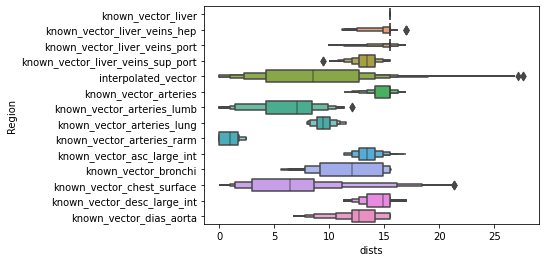

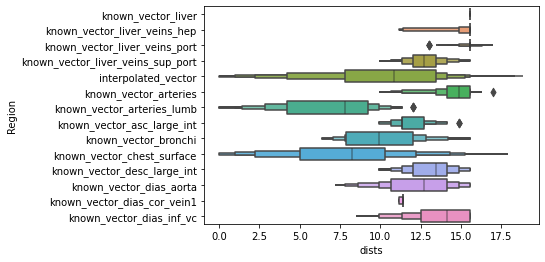

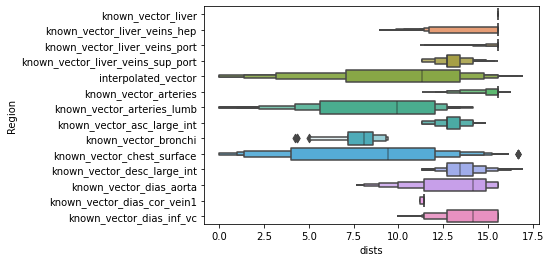

In [9]:
res = pd.DataFrame()
bxpDict = {}
for i in range(len(dh.x_val)):
    fig = plt.plot()
    fixed_image = sitk.ReadImage(fixed_image_paths[i])
    moving_landmarks, fixed_landmarks, regions = get_landmarks(fixed_image_paths[i], indexing='xyz')
    df = pd.DataFrame()
    df['Region'] = regions
    order = df.groupby(df['Region']).value_counts().index
    order = order[order.str.contains('liver')].tolist() + order[0:10].tolist()
    df['dists'] = np.linalg.norm(moving_landmarks - fixed_landmarks, axis = 1)
    bxpDict[f'bxp{i}'] = sns.boxenplot(data = df, x = 'dists', y = 'Region', order = order)
    plt.show()

In [ ]:
## Show all fixed images
fixedImages = {f'fixed image {i}': sitk.ReadImage(fixed_image_paths[i]) for i in range(len(dh.x_val))}
from pyM2aia import M2aiaOnlineHelper
M2aiaHelper = M2aiaOnlineHelper("ipynbViewer", "jtfc.de:5050/m2aia/m2aia-no-vnc:with_exit", "8899")
with M2aiaHelper as helper: helper.show(fixedImages)